# Purpose of this simulation


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tables

import numpy as np
np.set_printoptions(precision=2, suppress=True)

# ideas

In [2]:

#for comparision
# exp_conds = ['wo_feature_selection', 
#              'w_iter_feature_selection',
#             'start_with_high_SNR_neurons']

# for e in exp_conds: print(e)


In [3]:
#for comparision

exp_conds = ['wo_feature_selection', 

             'w_iter_feature_selection']



exp_conds = [e + f'_mfr_100' for e in exp_conds]
for e in exp_conds: print(e)

wo_feature_selection_mfr_100
w_iter_feature_selection_mfr_100


# Preproc the feature files

In [4]:
import aopy
import tables
import os

def load_feature_selection_files(data_dump_folder, exp_conds):
    """
    load feature selection from data dump folder
    
    Args;
    
    Returns:
        exp_data_all: a list of exp_data as parsed by bmi3d
        exp_data_metadata_all: a list of exp_metadata as parsed by bmi3d
    """

    exp_data_all = list()
    exp_data_metadata_all = list()

    for e in exp_conds:
        files = {'hdf':e+'.h5'}
        file_name = files['hdf']
        d,m = aopy.preproc.parse_bmi3d(data_dump_folder, files)

        #also load the clda and feature selection files

        feature_selection_data = aopy.data.load_hdf_group(data_dump_folder, file_name,'feature_selection')
        d['feature_selection'] =  feature_selection_data

        exp_data_all.append(d)
        exp_data_metadata_all.append(m)
        
    return (exp_data_all, exp_data_metadata_all)

In [5]:
data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/'

(exp_data_all, exp_data_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)

exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

In [6]:
exp_data_all[0]['bmi3d_task'].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (32, 1)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (32, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('trial', '<u4', (1,)), ('plant_visible', '?', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

In [7]:
exp_data_all[0]['events']['event']

masked_array(data=[b'TIME_ZERO', b'TARGET_ON', b'CURSOR_ENTER_TARGET',
                   b'HOLD_PENALTY', b'TARGET_ON', b'TIMEOUT_PENALTY',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'REWARD',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'HOLD_PENALTY',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'HOLD_PENALTY',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'REWARD',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'HOLD_PENALTY',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'HOLD_PENALTY',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'HOLD_PENALTY',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'HOLD_PENALTY',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'REWARD',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'REWARD',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'HOLD_PENALTY',
                   b'TARGET_ON', b'CURSOR_ENTER_TARGET', b'REWARD',
 

# Check feature selection strategies

## display the strategies

In [8]:
def plot_feature_selection(active_feat_set_list, ax = None):
    """
    plot the selection strategy map. 
    """
    from matplotlib import colors
    
    
        
    active_feat_heat_map = np.array(active_feat_set_list, dtype = np.int32)
    active_feat_heat_map = np.ma.masked_where(active_feat_heat_map == False, active_feat_heat_map)
    

    
    if ax is None: 
        fig, ax = plt.subplots()
        print(type(ax))
        
        #color true to yellow
    cmap = colors.ListedColormap(['yellow'])
    ax.imshow(active_feat_heat_map, cmap = cmap)

   
    cmap.set_bad(color='blue')

    ax.set_ylabel('Learner batch')
    ax.set_xlabel('Feature index')





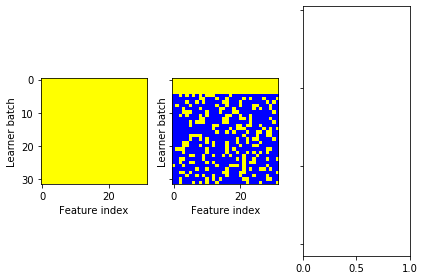

In [9]:
fig_feat_activity, ax_feat_activity = plt.subplots(1,3, sharey = True)

for e, a in zip(exp_data_all,  ax_feat_activity):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    
fig_feat_activity.tight_layout()


# Behaviour comparision

## count how many rewards

## Trial segments and trajectories

In [10]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

def get_cursor_trajectories_from_parsed_data(exp_data, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    
    events = exp_data['events']
    cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle

    streamed_code = events['code']
    event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

    trial_segments, trial_times = aopy.preproc.get_trial_segments(streamed_code, event_cycles, [20],  [REWARD, HOLD_PENALTY])
    trial_segments = np.array(trial_segments)
    trial_indices = [range(t[0], t[1]) for t in trial_times]
    cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
    
    return (cursor_trajectories, trial_segments, trial_times)

In [11]:
(cursor_trajectories, trial_segments, trial_times) = get_cursor_trajectories_from_parsed_data(exp_data_all[0], )

trial_segments

array([[20, 84, 64],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 48],
       [20, 84, 64],
       [20, 84, 48],
       [20, 84, 48]], dtype=uint8)

In [12]:
def calc_trial_times(trial_times):
    """
    for each row, calculate the difference between the last and first elements
    """
    row_index = 1 
    
    return np.apply_along_axis(lambda row: row[-1] - row[0], row_index, trial_times)

print(trial_times)
calc_trial_times(trial_times)

[[ 1370  1560]
 [ 2575  2652]
 [ 4898  5017]
 [ 5203  5287]
 [ 6313  6402]
 [ 6926  7008]
 [ 8378  8497]
 [ 9074  9193]
 [ 9763  9847]
 [10615 10728]
 [12284 12390]
 [12871 12979]
 [13705 13800]
 [14558 14700]
 [16280 16416]
 [17161 17286]]


array([190,  77, 119,  84,  89,  82, 119, 119,  84, 113, 106, 108,  95,
       142, 136, 125], dtype=uint64)

In [13]:
# get the unique target positions

from typing import List, Dict
import seaborn as sns


def plot_cursor_trajectories(cursor_trajectories: List, exp_data:Dict, exp_metadata,ax = None):

    fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)


    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    
    sns.color_palette("dark:salmon_r", as_cmap=True)

    aopy.visualization.plot_trajectories(cursor_trajectories, bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, ax = ax)

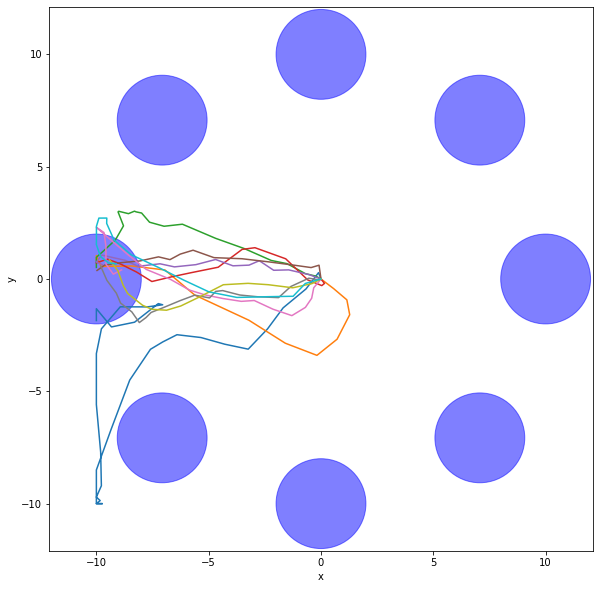

In [14]:
plot_cursor_trajectories(cursor_trajectories[:10], exp_data_all[0], exp_data_metadata_all[0])

In [15]:
cursor_trajectories[0]

array([[  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [ -0.11,   0.28],
       [ -0.11,   0.28],
       [ -0.11,   0.28],
       [ -0.11,   0.28],
       [ -0.11,   0.28],
       [ -0.11,   0.28],
       [ -0.67,  -0.44],
       [ -0.67,  -0.44],
       [ -0.67,  -0.44],
       [ -0.67,  -0.44],
       [ -0.67,  -0.44],
       [ -0.67,  -0.44],
       [ -1.69,  -1.28],
       [ -1.69,  -1.28],
       [ -1.69,  -1.28],
       [ -1.69,  -1.28],
       [ -1.69,  -1.28],
       [ -1.69,  -1.28],
       [ -2.38,  -2.22],
       [ -2.38,  -2.22],
       [ -2.38,  -2.22],
       [ -2.38,  -2.22],
       [ -2.38,  -2.22],
       [ -2.38,  -2.22],
       [ -3.24,  -3.12],
       [ -3.24,  -3.12],
       [ -3.24,  -3.12],
       [ -3.24,  -3.12],
       [ -3.24,  -3.12],
       [ -3.24,  -3.12],
       [ -4.28,  -2.9 ],
       [ -4.28,  -2.9 ],
       [ -4.28,  -2.9 ],
       [ -4.28,  -2.9 ],
       [ -4.28,  -2.9 ],
       [ -4.28,  -2.9 ],
       [ -5.34,  -2.61],


# Post data analysis

# Behaviour  analyses

## Trajectory analysis

In [16]:
def calculate_traj_length(trajectories):
    """
    given a list of trajectories, calculate each trajectory's length
    
    args:
        trajectories[np.ndarray]: number of data points by number of dims
    """
    traj_length = np.empty((len(trajectories)))
    
    for i,t in enumerate(trajectories):
        delta = np.diff(t, axis = 0)
        
        
        delta_length = delta**2
        
        
        delta_sum = np.sum(delta_length, axis = 1) ** (1/2)
        
        delta_sum = np.sum(delta_sum)
        
        traj_length[i] = delta_sum
        
    return traj_length
        
        

def test_calculate_traj_length():
    
    
    #test a line segment length
    cursor_trajectory = np.arange(0,1, 0.1).reshape(-1,1)
    expected_trajectory_length = np.array([0.9])
    calculated_trajectory_length = calculate_traj_length([cursor_trajectory])
    
    np.testing.assert_array_equal(expected_trajectory_length, calculated_trajectory_length)
    
    
test_calculate_traj_length()    

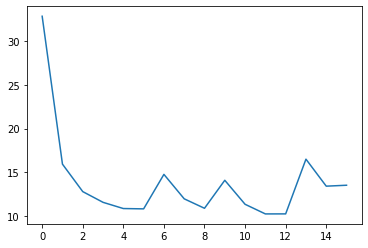

In [17]:
cursor_length = calculate_traj_length(cursor_trajectories)

plt.plot(cursor_length)

## Variance analysis

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [18]:
clda_log = exp_data_all[0]['bmi3d_clda']


In [19]:
exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

30.0


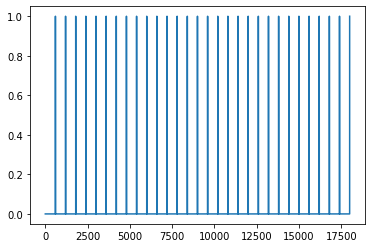

In [20]:
plt.plot(exp_data_all[0]['task']['update_bmi'])
print(np.sum(exp_data_all[0]['task']['update_bmi']))

In [21]:
print(clda_log['kf_C'][-1])

[[ 0.    0.    0.    3.16  0.    0.21 47.03]
 [ 0.    0.    0.   -0.21  0.    3.25 47.56]
 [ 0.    0.    0.   -2.73  0.   -0.07 46.33]
 [ 0.    0.    0.   -0.06  0.   -2.33 48.27]
 [ 0.    0.    0.    3.01  0.   -0.27 46.97]
 [ 0.    0.    0.   -0.1   0.    2.73 47.84]
 [ 0.    0.    0.   -2.1   0.   -0.43 44.83]
 [ 0.    0.    0.    0.04  0.   -2.2  48.41]
 [ 0.    0.    0.    2.62  0.    0.09 45.49]
 [ 0.    0.    0.   -0.68  0.    2.94 48.09]
 [ 0.    0.    0.   -2.8   0.    0.58 51.06]
 [ 0.    0.    0.   -0.15  0.   -2.56 47.41]
 [ 0.    0.    0.    2.32  0.    0.65 48.67]
 [ 0.    0.    0.    0.06  0.    3.75 48.18]
 [ 0.    0.    0.   -3.71  0.   -0.11 48.73]
 [ 0.    0.    0.    0.31  0.   -2.41 47.01]
 [ 0.    0.    0.    3.37  0.   -0.52 48.82]
 [ 0.    0.    0.   -0.06  0.    2.6  45.78]
 [ 0.    0.    0.   -2.99  0.    0.52 48.1 ]
 [ 0.    0.    0.    0.57  0.   -2.33 47.88]
 [ 0.    0.    0.    2.78  0.    0.19 49.43]
 [ 0.    0.    0.   -0.03  0.    3.25 46.41]
 [ 0.    0

## decoder

In [22]:
exp_data_all[0]['feature_selection'].keys()

dict_keys(['C_mat', 'K_mat', 'Q_diag', 'assist_level', 'batch_size', 'batch_time', 'feat_set', 'fixed_noise_level', 'half_life', 'n_starting_feats', 'n_states', 'noise_mode', 'noise_neuron_list', 'percent_noise', 'sim_C', 'total_exp_time', 'transform_x_flag', 'transform_y_flag'])

(31, 32, 7)


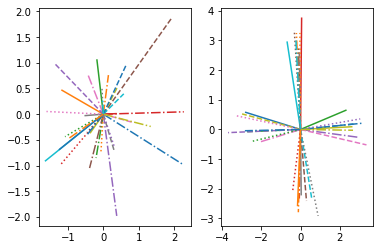

In [23]:
from afs_plotting import plot_prefered_directions

C_mat = exp_data_all[0]['feature_selection']['C_mat']

print(C_mat.shape)



fig, ax = plt.subplots(1,2)

plot_prefered_directions(C_mat[0], ax = ax[0])
plot_prefered_directions(C_mat[-1], ax = ax[1])

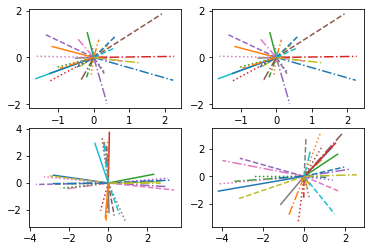

In [34]:
from afs_plotting import plot_prefered_directions

def plot_all_initial_C_mat(exp_data_all):
    
    """
    just compare initial C mat with the last C_mat
    """
    
    N_EXP = len(exp_data_all)
    
    fig, ax = plt.subplots(2, N_EXP)
    
    for i in range(N_EXP):
        C_mat = exp_data_all[i]['feature_selection']['C_mat']
        plot_prefered_directions(C_mat[0], ax = ax[0,i])
        plot_prefered_directions(C_mat[-1], ax = ax[1,i])
        

plot_all_initial_C_mat(exp_data_all)

## Decoder compared to the encoder



In [25]:


neuron_types = ['noisy', 'non_noisy']

n_neurons = 32
n_neurons_noisy_group = 24
n_neurons_no_noise_group = 8


noise_neuron_ind = np.arange(n_neurons_noisy_group)
no_noise_neuron_ind = np.arange(n_neurons_noisy_group, n_neurons_noisy_group + n_neurons_no_noise_group)

neuron_type_indices_in_a_list = [
    noise_neuron_ind, 
    no_noise_neuron_ind
]


noise_neuron_list = np.full(n_neurons, False, dtype = bool)
no_noise_neuron_list = np.full(n_neurons, False, dtype = bool)


noise_neuron_list[noise_neuron_ind] = True
no_noise_neuron_list[no_noise_neuron_ind] = True



neuron_type_bool_list = [
    noise_neuron_list,
    no_noise_neuron_list,
]

N_TYPES_OF_NEURONS = 2

print('We have two types of indices: ')
for t,l in enumerate(neuron_type_indices_in_a_list): print(f'{neuron_types[t]}:{l}')

We have two types of indices: 
noisy:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
non_noisy:[24 25 26 27 28 29 30 31]


In [26]:
exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

(31, 32, 7)
(31, 32, 7)


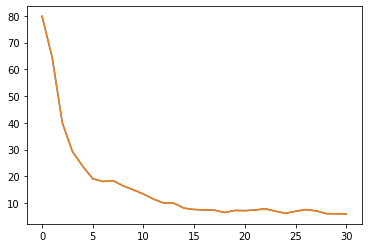

In [27]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix


feature_selection_data = exp_data_all[0]['feature_selection']
active_feat_set = feature_selection_data['feat_set']
active_feat_set_last = active_feat_set[-1]


for i,e in enumerate(exp_conds):
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['C_mat']
    
    print(dec_directions.shape)

    angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                               enc_directions)
    
#     if i == 0:
#         active_angles = np.mean(angles_hist[:,noise_neuron_list], axis = 1)
#         plt.plot(active_angles)
    
    active_angles = np.mean(angles_hist[:,active_feat_set_last], axis = 1)
    
    plt.plot(active_angles)



## looking at K matrix

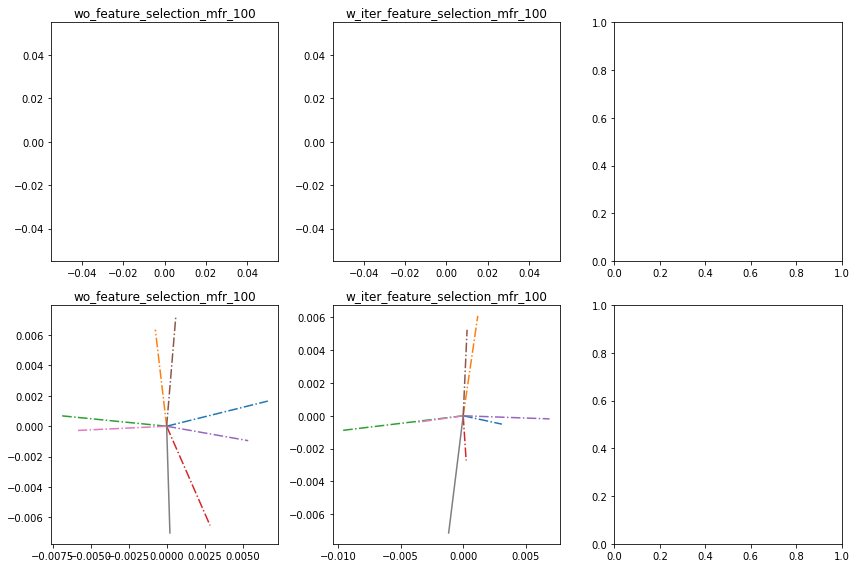

In [28]:
NUM_EXP = 3
GLOBAL_FIGURE_VERTICAL_SIZE  = 4

figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))



#compare the K matrix before the exp
for i,e in enumerate(exp_conds):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    K = K_mat[0].T

    plot_prefered_directions(K[no_noise_neuron_ind, :], ax  = axes_k_matrix[0, i])
    axes_k_matrix[0, i].set_title(exp_conds[i])

#compare to the matrix after the exp
for i,e in enumerate(exp_conds):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    
    K = K_mat[-1].T
    plot_prefered_directions(K[no_noise_neuron_ind,:], ax  = axes_k_matrix[1, i])
    axes_k_matrix[1,i].set_title(exp_conds[i])
    
    
figure_k_matrix.tight_layout()

# Feature analysis

## examine used C mat

In [29]:
import sympy as sp
sp.Matrix(exp_data_all[0]['feature_selection']['C_mat'][1])

Matrix([
[0.0, 0.0, 0.0,     2.25053014599775, 0.0, -0.937777345005372, 7.84735081539942],
[0.0, 0.0, 0.0,    0.356072952358535, 0.0,   1.18506041497446, 7.89869806636717],
[0.0, 0.0, 0.0,   -0.714801225314675, 0.0, -0.786175151142753, 3.83458493712159],
[0.0, 0.0, 0.0,     2.18972878821037, 0.0, -0.154246881674266, 8.14305134212385],
[0.0, 0.0, 0.0,    0.553255688334004, 0.0,  -1.82534609115077, 4.58690272894732],
[0.0, 0.0, 0.0,   -0.244531374891122, 0.0, -0.536413807763381, 6.08488722927213],
[0.0, 0.0, 0.0,   -0.709902844610349, 0.0,  0.544093891509145, 5.77493833317743],
[0.0, 0.0, 0.0,   -0.474721795034227, 0.0, -0.439960093990063, 8.79145472706896],
[0.0, 0.0, 0.0,  -0.0814505829036198, 0.0, -0.470268507059112, 4.88982288149672],
[0.0, 0.0, 0.0,    -1.38946456769314, 0.0, -0.376386159999902, 6.88512987672257],
[0.0, 0.0, 0.0,     -1.6094805927699, 0.0, -0.638913385461413, 4.53701338502621],
[0.0, 0.0, 0.0,    -1.13972745666634, 0.0,  0.177369754339815, 5.39310097796397],
[0.0, 0

(32, 7)
(32, 7)


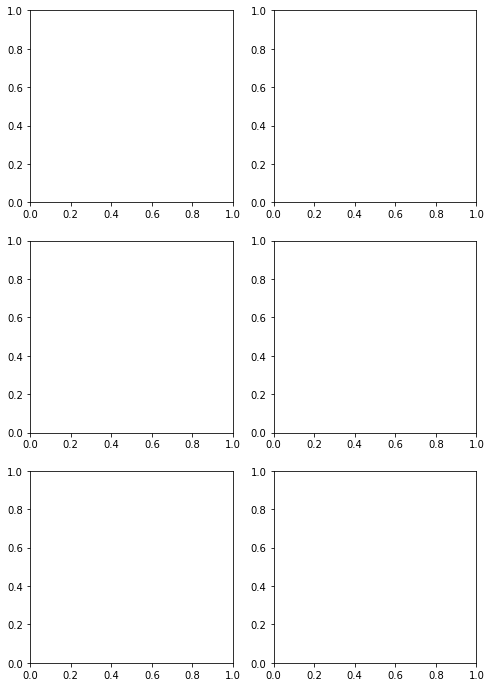

In [30]:
import weights_linear_regression
importlib.reload(weights_linear_regression)
from weights_linear_regression import calc_a_history_of_matrix_L2norms_along_first_axis


figure_weights_norm, axes_weights_norm = plt.subplots( NUM_EXP, N_TYPES_OF_NEURONS,
    figsize = (N_TYPES_OF_NEURONS * GLOBAL_FIGURE_VERTICAL_SIZE, NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE))

C_mat_all = list()

for j,e in enumerate(exp_conds):
    
    C_mat_list = exp_data_all[j]['feature_selection']['C_mat']
    
    updated_C_mat = np.array(C_mat_list)
    the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(updated_C_mat, debug = False)

    C_mat_all.append(np.copy(updated_C_mat))
    axe_exp = axes_weights_norm[j,:]

        
C_mat_all = np.array(C_mat_all)

In [31]:
fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list
encoder_C



for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C = ,
                                                                indices_to_sum=(X_VEL_STATE_IND, Y_VEL_STATE_IND))


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
    
#axes_compr_means.set_title('Means of the high SNR weight trajectory')

SyntaxError: invalid syntax (<ipython-input-31-7f984e87388b>, line 18)